# Analysis of NeXT cube monitor bus

## Verilog_VCD module by ???

In [1]:
# This is a manual translation, from perl to python, of :
# http://cpansearch.perl.org/src/GSULLIVAN/Verilog-VCD-0.03/lib/Verilog/VCD.pm 

import re

global timescale
global endtime

def croak(*args):
  """Function similar to Perl's Carp::croak, to simplify porting this code"""
  a = "".join(args);
  raise Exception(a)

def list_sigs(file) :
    """Parse input VCD file into data structure, 
    then return just a list of the signal names."""

    vcd = parse_vcd(file, only_sigs=1)

    sigs = []
    for k in list(vcd.keys()):
        v = vcd[k]
        nets = v['nets']
        sigs.extend( n['hier']+'.'+n['name'] for n in nets )
    
    return sigs


def parse_vcd(file, only_sigs=0, use_stdout=0, siglist=[], opt_timescale=''):
    """Parse input VCD file into data structure.
    Also, print t-v pairs to STDOUT, if requested."""

    global endtime

    usigs = {}
    for i in siglist:
        usigs[i] = 1

    if len(usigs):
        all_sigs = 0
    else :
        all_sigs = 1

    data = {}
    mult = 0
    num_sigs = 0
    hier = []
    time = 0

    re_time    = re.compile(r"^#(\d+)")
    re_1b_val  = re.compile(r"^([01zxZX])(.+)")
    re_Nb_val  = re.compile(r"^[br](\S+)\s+(.+)")

    fh = open(file, 'r')
    while True:
        line = fh.readline()
        if line == '' : # EOF
          break

        # chomp
        # s/ ^ \s+ //x
        line = line.strip()

        if "$enddefinitions" in line:
            num_sigs = len(data)
            if (num_sigs == 0) :
                if (all_sigs) :
                    croak("Error: No signals were found in the VCD file file.",
                          'Check the VCD file for proper var syntax.')
                
                else :
                    croak("Error: No matching signals were found in the VCD file file.",
                          ' Use list_sigs to view all signals in the VCD file.')
                
            
            if ((num_sigs>1) and use_stdout) :
                croak("Error: There are too many signals (num_sigs) for output ",
                      'to STDOUT.  Use list_sigs to select a single signal.')
            
            if only_sigs:
                break


        elif "$timescale" in line:
            statement = line
            if not "$end" in line:
                while fh :
                    line = fh.readline()
                    statement += line
                    if "$end" in line:
                      break
            
            mult = calc_mult(statement, opt_timescale)
        

        elif "$scope" in line:
            # assumes all on one line
            #   $scope module dff end
            hier.append( line.split()[2] ) # just keep scope name
        
        elif "$upscope" in line:
            hier.pop()
        
        elif "$var" in line:
            # assumes all on one line:
            #   $var reg 1 *@ data $end
            #   $var wire 4 ) addr [3:0] $end
            ls = line.split()
            type = ls[1]
            size = ls[2]
            code = ls[3]
            name = "".join(ls[4:-1])
            path = '.'.join(hier)
            full_name = path + name
            if (full_name in usigs) or all_sigs :
              if code not in data :
                data[code] = {}
              if 'nets' not in data[code]:
                data[code]['nets'] = []
              var_struct = {
                  'type' : type,
                  'name' : name,
                  'size' : size,
                  'hier' : path,
               } 
              if var_struct not in data[code]['nets']:
                data[code]['nets'].append( var_struct )
        

        elif line.startswith('#'):
            re_time_match   = re_time.match(line)
            time = mult * int(re_time_match.group(1))
            endtime = time
        

        elif line.startswith(('0', '1', 'x', 'z', 'b', 'r', 'Z', 'X')):
            re_1b_val_match = re_1b_val.match(line)
            re_Nb_val_match = re_Nb_val.match(line)
            if re_Nb_val_match :
              value = re_Nb_val_match.group(1)
              code  = re_Nb_val_match.group(2)
            elif re_1b_val_match :
              value = re_1b_val_match.group(1)
              code  = re_1b_val_match.group(2)
            if (code in data) :
                if (use_stdout) :
                    print(time, value)
                else :
                    if 'tv' not in data[code]:
                      data[code]['tv'] = []
                    data[code]['tv'].append( (time, value) )
                
            
        
    
    fh.close()

    return data


def calc_mult (statement, opt_timescale=''):
    """ 
    Calculate a new multiplier for time values.
    Input statement is complete timescale, for example:
      timescale 10ns end
    Input new_units is one of s|ms|us|ns|ps|fs.
    Return numeric multiplier.
    Also sets the package timescale variable.
    """ 

    global timescale

    fields = statement.split()
    fields.pop()   # delete end from array
    fields.pop(0)  # delete timescale from array
    tscale = ''.join(fields)

    new_units = ''
    if (opt_timescale != ''):
        new_units = opt_timescale.lower()
        new_units = re.sub(r"\s", '', new_units)
        timescale = "1"+new_units
    
    else :
        timescale = tscale
        return 1
    

    mult = 0
    units = 0
    ts_match = re.compile(r"(\d+)([a-z]+)")
    if ts_match.match(tscale):
        mult  = ts_match.group(1)
        units = ts_match.group(2).lower()
    
    else :
        croak("Error: Unsupported timescale found in VCD file: tscale.  ",
              'Refer to the Verilog LRM.')
    

    mults = {
        'fs' : 1e-15,
        'ps' : 1e-12,
        'ns' : 1e-09,
        'us' : 1e-06,
        'ms' : 1e-03,
         's' : 1e-00,
    }
    mults_keys = keys(mults)
    mults_keys.sort(key=lambda x : mults[x])
    usage = '|'.join(mults_keys)

    scale = 0
    if units in mults :
        scale = mults[units]
    
    else :
        croak("Error: Unsupported timescale units found in VCD file: "+units+".  ",
              "Supported values are: "+usage)
    

    new_scale = 0
    if new_units in mults :
        new_scale = mults[new_units]
    
    else :
        croak("Error: Illegal user-supplied timescale: "+new_units+".  ",
              "Legal values are: "+usage)
    

    return ((mult * scale) / new_scale)


def get_timescale() :
    return timescale


def get_endtime() :
    return endtime



# =head1 NAME
# 
# Verilog_VCD - Parse a Verilog VCD text file
# 
# =head1 VERSION
# 
# This document refers to Verilog::VCD version 0.03.
# 
# =head1 SYNOPSIS
# 
#     from Verilog_VCD import parse_vcd
#     vcd = parse_vcd('/path/to/some.vcd')
# 
# =head1 DESCRIPTION
# 
# Verilog is a Hardware Description Language (HDL) used to model digital logic.
# While simulating logic circuits, the values of signals can be written out to
# a Value Change Dump (VCD) file.  This module can be used to parse a VCD file
# so that further analysis can be performed on the simulation data.  The entire
# VCD file can be stored in a Python data structure and manipulated using
# standard hash and array operations.  This module is also a good helper for
# parsing fsdb files, since you can run fsd2vcd(part of the novas installation)
# to convert them to the vcd format and then use this module.
# 
# =head2 Input File Syntax
# 
# The syntax of the VCD text file is described in the documentation of
# the IEEE standard for Verilog.  Only the four-state VCD format is supported.
# The extended VCD format (with strength information) is not supported.
# Since the input file is assumed to be legal VCD syntax, only minimal
# validation is performed.
# 
# =head1 SUBROUTINES
# 
# 
# =head2 parse_vcd(file, $opt_ref)
# 
# Parse a VCD file and return a reference to a data structure which
# includes hierarchical signal definitions and time-value data for all
# the specified signals.  A file name is required.  By default, all
# signals in the VCD file are included, and times are in units
# specified by the C<$timescale> VCD keyword.
# 
#     vcd = parse_vcd('/path/to/some.vcd')
# 
# It returns a reference to a nested data structure.  The top of the
# structure is a Hash-of-Hashes.  The keys to the top hash are the VCD
# identifier codes for each signal.  The following is an example
# representation of a very simple VCD file.  It shows one signal named
# C<chip.cpu.alu.clk>, whose VCD code is C<+>.  The time-value pairs
# are stored as an Array-of-Tuples, referenced by the C<tv> key.  The
# time is always the first number in the pair, and the times are stored in
# increasing order in the array.
# 
#     {
#       '+' : {
#                'tv' : [
#                          (
#                            0,
#                            '1'
#                          ),
#                          (
#                            12,
#                            '0'
#                          ),
#                        ],
#                'nets' : [
#                            {
#                              'hier' : 'chip.cpu.alu.',
#                              'name' : 'clk',
#                              'type' : 'reg',
#                              'size' : '1'
#                            }
#                          ]
#              }
#     }
# 
# Since each code could have multiple hierarchical signal names, the names are
# stored as an Array-of-Hashes, referenced by the C<nets> key.  The example above
# only shows one signal name for the code.
# 
# 
# =head3 OPTIONS
# 
# Options to C<parse_vcd> should be passed as a hash reference.
# 
# =over 4
# 
# =item timescale
# 
# It is possible to scale all times in the VCD file to a desired timescale.
# To specify a certain timescale, such as nanoseconds:
# 
#     vcd = parse_vcd(file, opt_timescale='ns'})
# 
# Valid timescales are:
# 
#     s ms us ns ps fs
# 
# =item siglist
# 
# If only a subset of the signals included in the VCD file are needed,
# they can be specified by a signal list passed as an array reference.
# The signals should be full hierarchical paths separated by the dot
# character.  For example:
# 
#     signals = [
#         'top.chip.clk',
#         'top.chip.cpu.alu.status',
#         'top.chip.cpu.alu.sum[15:0]',
#     ]
#     vcd = parse_vcd(file, siglist=signals)
# 
# Limiting the number of signals can substantially reduce memory usage of the
# returned data structure because only the time-value data for the selected
# signals is loaded into the data structure.
# 
# =item use_stdout
# 
# It is possible to print time-value pairs directly to STDOUT for a
# single signal using the C<use_stdout> option.  If the VCD file has
# more than one signal, the C<siglist> option must also be used, and there
# must only be one signal specified.  For example:
# 
#     vcd = parse_vcd(file, 
#                     use_stdout=1,
#                     siglist=['top.clk']
#                 )
# 
# The time-value pairs are output as space-separated tokens, one per line.
# For example:
# 
#     0 x
#     15 0
#     277 1
#     500 0
# 
# Times are listed in the first column.
# Times units can be controlled by the C<timescale> option.
# 
# =item only_sigs
# 
# Parse a VCD file and return a reference to a data structure which
# includes only the hierarchical signal definitions.  Parsing stops once
# all signals have been found.  Therefore, no time-value data are
# included in the returned data structure.  This is useful for
# analyzing signals and hierarchies.
# 
#     vcd = parse_vcd(file, only_sigs=1)
# 
# =back
# 
# 
# =head2 list_sigs(file)
# 
# Parse a VCD file and return a list of all signals in the VCD file.
# Parsing stops once all signals have been found.  This is
# helpful for deciding how to limit what signals are parsed.
# 
# Here is an example:
# 
#     signals = list_sigs('input.vcd')
# 
# The signals are full hierarchical paths separated by the dot character
# 
#     top.chip.cpu.alu.status
#     top.chip.cpu.alu.sum[15:0]
# 
# =head2 get_timescale( )
# 
# This returns a string corresponding to the timescale as specified
# by the C<$timescale> VCD keyword.  It returns the timescale for
# the last VCD file parsed.  If called before a file is parsed, it
# returns an undefined value.  If the C<parse_vcd> C<timescale> option
# was used to specify a timescale, the specified value will be returned
# instead of what is in the VCD file.
# 
#     vcd = parse_vcd(file); # Parse a file first
#     ts  = get_timescale();  # Then query the timescale
# 
# =head2 get_endtime( )
# 
# This returns the last time found in the VCD file, scaled
# appropriately.  It returns the last time for the last VCD file parsed.
# If called before a file is parsed, it returns an undefined value.
# 
#     vcd = parse_vcd(file); # Parse a file first
#     et  = get_endtime();    # Then query the endtime
# 
# =head1 EXPORT
# 
# Nothing is exported by default.  Functions may be exported individually, or
# all functions may be exported at once, using the special tag C<:all>.
# 
# =head1 DIAGNOSTICS
# 
# Error conditions cause the program to raise an Exception.
# 
# =head1 LIMITATIONS
# 
# Only the following VCD keywords are parsed:
# 
#     $end                $scope
#     $enddefinitions     $upscope
#     $timescale          $var
# 
# The extended VCD format (with strength information) is not supported.
# 
# The default mode of C<parse_vcd> is to load the entire VCD file into the
# data structure.  This could be a problem for huge VCD files.  The best solution
# to any memory problem is to plan ahead and keep VCD files as small as possible.
# When simulating, dump fewer signals and scopes, and use shorter dumping
# time ranges.  Another technique is to parse only a small list of signals
# using the C<siglist> option; this method only loads the desired signals into
# the data structure.  Finally, the C<use_stdout> option will parse the input VCD
# file line-by-line, instead of loading it into the data structure, and directly
# prints time-value data to STDOUT.  The drawback is that this only applies to
# one signal.
# 
# =head1 BUGS
# 
# There are no known bugs in this module.
# 
# =head1 SEE ALSO
# 
# Refer to the following Verilog documentation:
# 
#     IEEE Standard for Verilog (c) Hardware Description Language
#     IEEE Std 1364-2005
#     Section 18.2, "Format of four-state VCD file"
# 
# =head1 AUTHOR
# 
# Originally written in Perl by Gene Sullivan (gsullivan@cpan.org)
# Translated into Python by Sameer Gauria (sgauria+python@gmail.com)
#
# Plus the following patches :
#  - Scott Chin : Handle upper-case values in VCD file.
#  - Sylvain Guilley : Fixed bugs in list_sigs.
#  - Bogdan Tabacaru : Fix bugs in globalness of timescale and endtime
#  - Andrew Becker : Fix bug in list_sigs
# Thanks!
# 
# =head1 COPYRIGHT AND LICENSE
# 
# Copyright (c) 2012 Gene Sullivan, Sameer Gauria.  All rights reserved.
# 
# This module is free software; you can redistribute it and/or modify
# it under the same terms as Perl itself.  See L<perlartistic|perlartistic>.
# 
# =cut



***
## IMPORTS

In [296]:
import matplotlib.pyplot as plt
% matplotlib inline
# NB: this will propbably carry over to other pyplot stuff... neeed to unset it
plt.rcParams['figure.figsize'] = (16.0, 4.0)
#from bokeh.charts import Step, show
#from bokeh.io import output_notebook
import numpy as np
from collections import OrderedDict
#output_notebook()
from statistics import median, mean, stdev
from random import sample

***
## DATA LOADING AND STORAGE

In [3]:
class VcdSignal:
    def __init__(self, raw_data):
        '''raw_data is a bit of a misnomer, 
        because its a single key/value of the output of parse_vcd '''
        self.data = [(p, int(q)) for p,q in raw_data['tv']]
        nets_data = raw_data['nets'][0]
        [setattr(self,key,nets_data[key]) for key in iter(nets_data)]

In [4]:
def steppy(data):
    ''' this does two things:
    first, reshapes [(x,y)...(xn,yn)] to [(x1...xn), (y1...yn)] because pyplot is ridiculous
    second, inserts "corners" into data so it plots as step chart
    does NOT plot it.
    still needs to be plotted as plot(*steppy(data)) because fucking pyplot'''
    newdata = []
    newdata.append(data[0])
    for pt in data[1:]:
        newdata.append((pt[0],(1,0)[pt[1]]))
        newdata.append(pt)
        
    return list(zip(*newdata))[0], list(zip(*newdata))[1]

In [5]:
file = 'mash_a.vcd'

In [6]:
data = parse_vcd(file)

In [7]:
signals = [s for s in data.keys()] # not the signal names
signals
signalNames = {'CLOCK':'#','MOCI':'"','MICO':'!'} # NB watch me

In [126]:
# Clock signal is too much for pyplot!
# NB ordering of [signals] changes
moci = VcdSignal(data[signalNames['MOCI']])
mico = VcdSignal(data[signalNames['MICO']])

In [9]:
## A timeseries chart in bokeh.
#t = list(zip(*test.data))[0]
#v = list(zip(*test.data))[1]
#blah = dict(x=t,y=v)
#ch = Step(blah, x='x',y='y');
#show(ch)

(-0.25, 1.25)

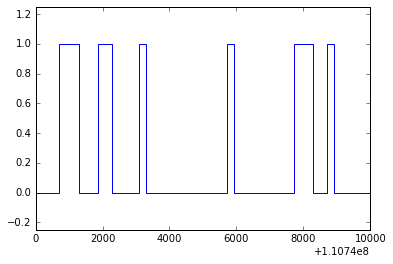

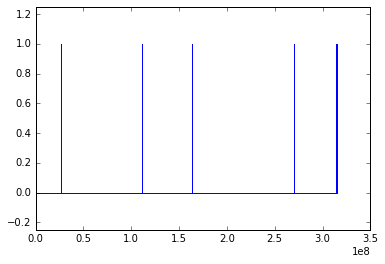

In [316]:
plt.plot(*steppy(moci.data))
plt.xlim(1.1074e8,1.1075e8)
plt.ylim(-0.25,1.25)
plt.figure()
plt.plot(*steppy(moci.data))
plt.ylim(-0.25,1.25)

___
## TIMING STABILITY

In [11]:
timescale # is global, baaaad

'1ns'

In [12]:
klok = VcdSignal(data[signalNames['CLOCK']])
#clock_ones = list(filter(lambda k: k[1]==1, klok.data))
#clock_zeros = list(filter(lambda k: k[1]==0, klok.data))
#clock_ones_timings = [clock_ones[p+1][0]-clock_ones[p][0] for p in range(len(clock_ones)-1)]
#clock_zeros_timings = [clock_zeros[p+1][0]-clock_zeros[p][0] for p in range(len(clock_zeros)-1)]
clock_half_timings = [klok.data[p+1][0]-klok.data[p][0] for p in range(len(klok.data)-1)]

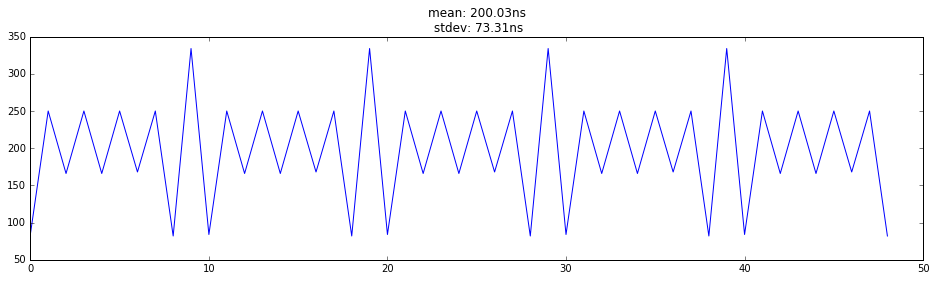

In [185]:
plt.plot(list(map(lambda x: x*2,clock_half_timings[1:50]))); # yowzer
# on average it's pretty accurate
# but, fuck
clkmean = 2*mean(clock_half_timings);
clkstd = 2*stdev(clock_half_timings);
plt.title('mean: '+str(round(clkmean,2))+'ns\n stdev: '+str(round(clkstd,2))+'ns');

***
## SIGNAL PROCESSING

In [14]:
'''taken verbatim from itertools documentation!'''
from itertools import islice, groupby

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [24]:
def timeBaseline(data):
    '''(t0, v) -> (t-t0 v)'''
    t0 = data[0][0]
    return list(map(lambda t: (t[0]-t0,t[1]), data))

In [136]:
def chunkSignals(data, timeout=100000):
    '''splits up data [(t0, 1|0)...(tn, 1|0)] into chunks
    based on time between events'''
    # TODO this is messed up: Doesn't return last signal chunk
    # timescale is 1ns??
    chunkedSignals = []
    currentChunk = []
    windowedData = window(data, n=2)
    # could rewrite using itertools.groupby???
    # could rewrite this a bunch of different ways
    for d in windowedData:
        if d[1][0]-d[0][0] > timeout:
            chunkedSignals.append(currentChunk)
            currentChunk = []
        currentChunk.append(d[1]) # assuming the first vakue is always garbage 0
    # you should feel really bad about this
    return list(filter(lambda k: len(k)>0,chunkedSignals))
    

In [81]:
# useless right now :)
from itertools import groupby

def runlength(data):
    return [(c,len(list(cgen))) for c,cgen in groupby(data)]

In [174]:
def inferRunlength(data, dt=200):
    return [round((b[1][0]-b[0][0])/200) for b in window(data,n=2)]

In [197]:
from itertools import starmap

def plotTracesOverlaid(data):
    '''plot everything overlaid, obviously.
    data is [[(t0,v0)...(tn,vn)],[],...]'''
    list(starmap(plt.plot,map(steppy, map(timeBaseline,data))))
    plt.ylim(-0.5, 1.5)
    plt.xlim(xmin=0);
    plt.xticks(list(range(-1000,10000,200)));
    plt.grid(b=1,axis='x')

In [194]:
def plotTraceWithRunlength(data, dt=200):
    '''plot trace with runlength, obviously
    data is [(t0,v0)...(tn,vn)]'''
    plt.plot(*steppy(timeBaseline(data)))
    plt.ylim(-0.25, 1.25)
    plt.xlim(xmin=-1000)
    list(map(lambda k: plt.annotate(k[1],k[0],fontsize=24),zip(timeBaseline(data),inferRunlength(data))))
    plt.xticks(list(range(-1000,10000,200)));
    plt.grid(b=1,axis='x')

In [281]:
from itertools import chain

def list2string(x):
    return ''.join(list(map(str,x)))

def string2bin(s):
    ''' "1010" -> "0b1010"'''
    return bin(int(s,2))

def string2hex(s):
    '''"1010" -> 0xA'''
    return hex(int(s,2))

def runlength2value(data):
    '''data is [(t0,v0)...(tn,vn)]
    e.g.,
    1 (3 timesteps) 0 (3 timesteps) -> [1,1,1,0,0,0]
    Right now, it will remain as a list because it'''
    # TODO you should be ashamed
    temp = list(zip(inferRunlength(data),list(zip(*data))[1]))
    return list(chain.from_iterable([list(t[1] for _ in range(t[0])) for t in temp]))

In [201]:
def averageTraces(data):
    '''average the timestamps of corresponding points in traces.
    this might involve a sequence alignment :) :) :)'''
    raise NotImplementedError

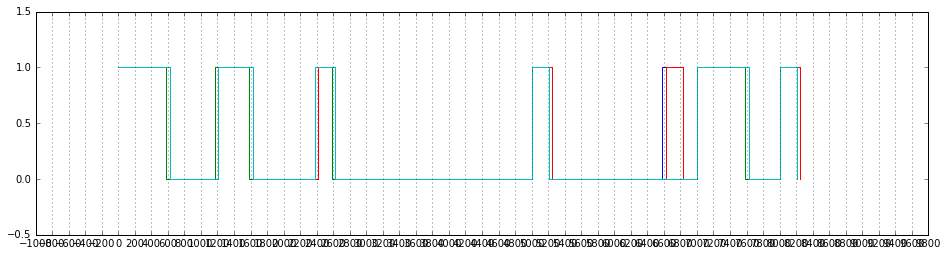

In [299]:
plotTracesOverlaid(chunkSignals(moci.data))

mash_a.vcd signal 1 of 4	(length 41)	0x1c6100080b9	0b11100011000010000000000001000000010111001
mash_a.vcd signal 2 of 4	(length 41)	0x1c610008039	0b11100011000010000000000001000000000111001
mash_a.vcd signal 3 of 4	(length 41)	0x1c6100080b9	0b11100011000010000000000001000000010111001
mash_a.vcd signal 4 of 4	(length 41)	0x1c610008039	0b11100011000010000000000001000000000111001


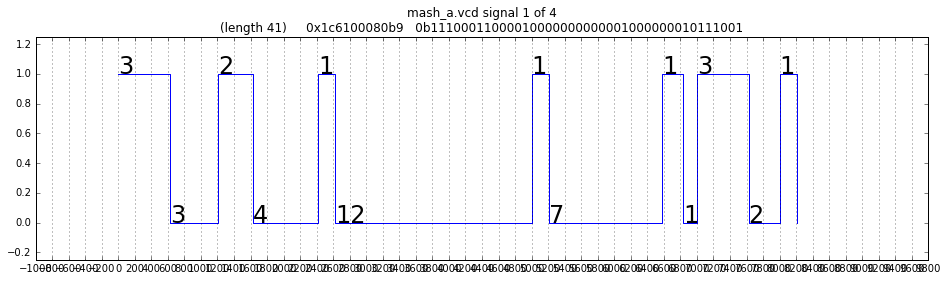

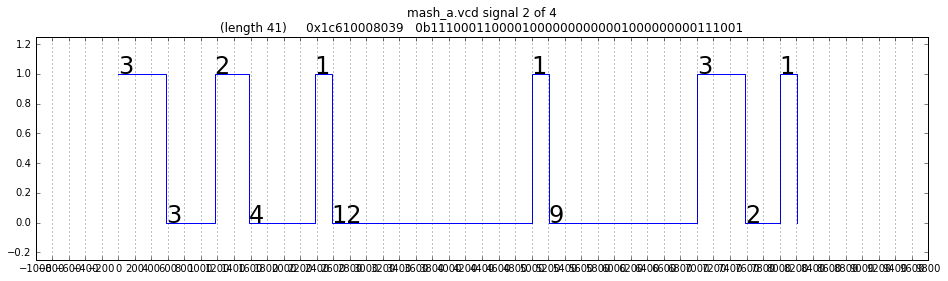

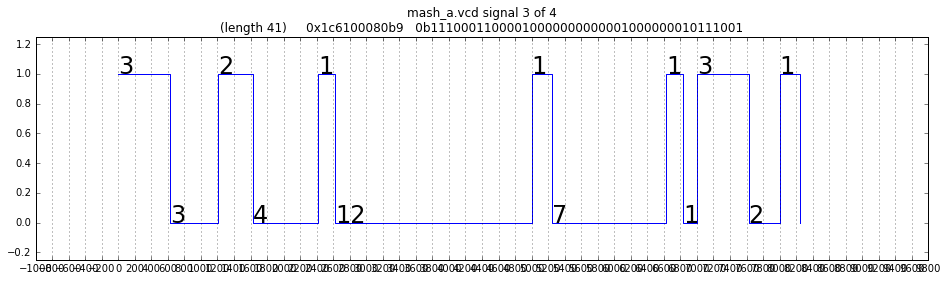

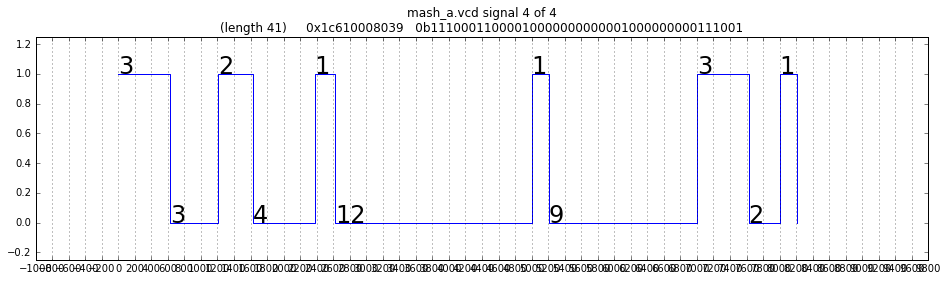

In [294]:
D = chunkSignals(moci.data)
for d in D:
    plt.figure()
    plotTraceWithRunlength(d)
    
    hex_value = string2hex(list2string(runlength2value(d)))
    bin_value = string2bin(list2string(runlength2value(d)))
    num_bits = str(len(list2string(runlength2value(d))))
    file_string = file+' signal '+str(D.index(d)+1)+' of '+str(len(D))
    desc_string = '(length '+num_bits+')\t'+hex_value+'\t'+bin_value
    
    plt.title(file_string+'\n'+desc_string.expandtabs())
    print(file_string+'\t'+desc_string)

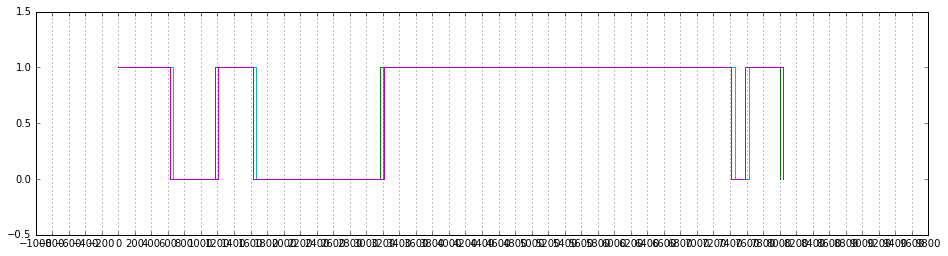

In [293]:
plotTracesOverlaid(chunkSignals(mico.data))

mash_a.vcd signal 1 of 5	(length 40)	0xe300fffffb	0b1110001100000000111111111111111111111011
mash_a.vcd signal 2 of 5	(length 40)	0xe300fffffb	0b1110001100000000111111111111111111111011
mash_a.vcd signal 3 of 5	(length 40)	0xe300fffffb	0b1110001100000000111111111111111111111011
mash_a.vcd signal 4 of 5	(length 40)	0xe300fffffb	0b1110001100000000111111111111111111111011
mash_a.vcd signal 5 of 5	(length 40)	0xe300fffffb	0b1110001100000000111111111111111111111011


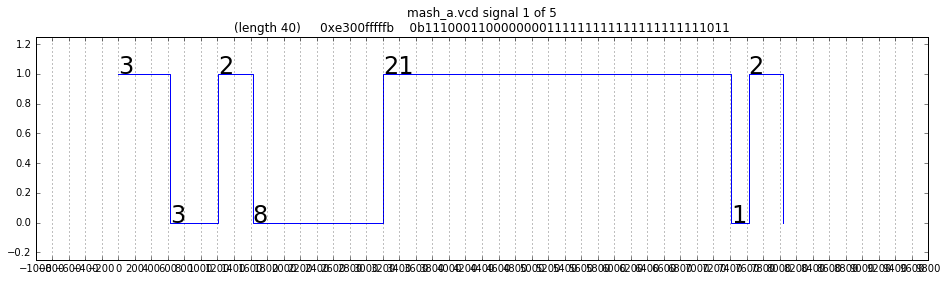

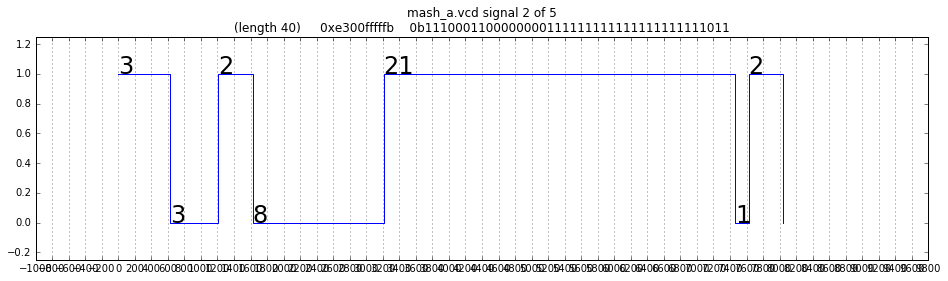

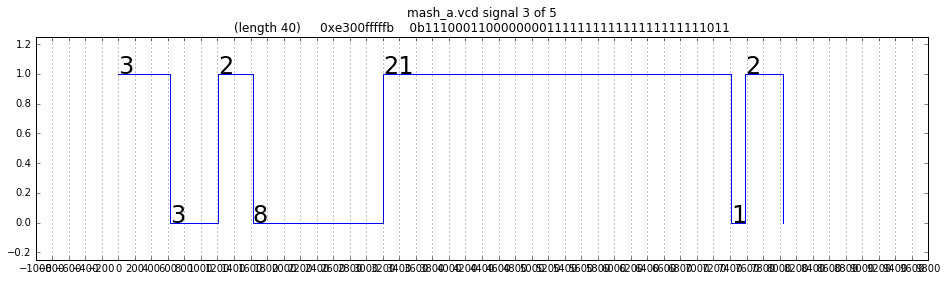

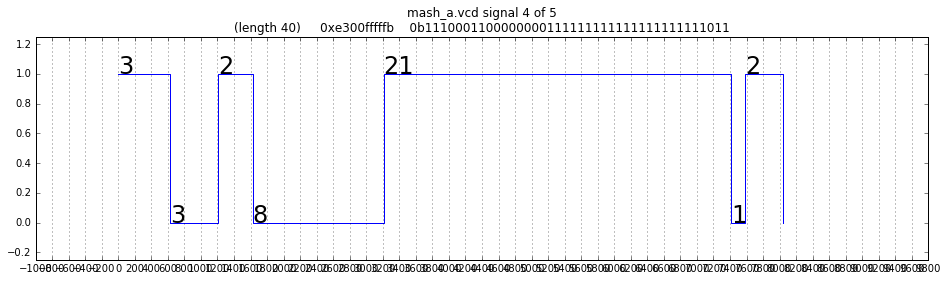

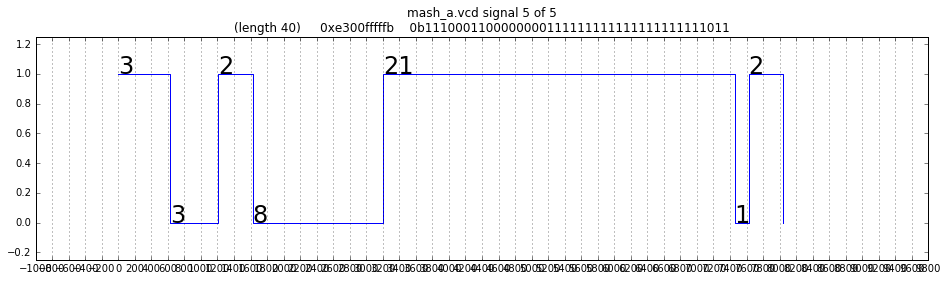

In [298]:
D = sample(chunkSignals(mico.data),5)
for d in D:
    plt.figure()
    plotTraceWithRunlength(d)
    
    hex_value = string2hex(list2string(runlength2value(d)))
    bin_value = string2bin(list2string(runlength2value(d)))
    num_bits = str(len(list2string(runlength2value(d))))
    file_string = file+' signal '+str(D.index(d)+1)+' of '+str(len(D))
    desc_string = '(length '+num_bits+')\t'+hex_value+'\t'+bin_value
    
    plt.title(file_string+'\n'+desc_string.expandtabs())
    print(file_string+'\t'+desc_string)